In [1]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
from google.cloud import storage 

# GCP | getting videose URLs from google cloud buckets

## Instantiate client and bucket

In [2]:
project_name="wagon-data-bootcamp-871"
base_url = "https://storage.googleapis.com"
bucket_name = "dance_871"
# Instantiates a client
client = storage.Client(project="wagon-data-bootcamp-871")
# Instantiates a bucket
bucket = client.bucket(bucket_name)

## Collecting video pathes/names

In [3]:
#get list of fine videos urls
videos_fine = [filename.name for filename in list(bucket.list_blobs(prefix='cutted/fine/dance_'))]
print(len(videos_fine))
#out example: public url eaample: https://storage.googleapis.com/wagon-data-871-wanli/vid/dance_jiggle.mp4
#print(videos_fine)
#out example: ['vid/dance_jiggle.mp4', 'vid/dance_jiggle_short.mp4']

#get list of fault videos urls
videos_fault = [filename.name for filename in list(bucket.list_blobs(prefix='cutted/fault/dance_'))]
print(len(videos_fault))

#combine videos 
all_videos = videos_fine + videos_fault
print(len(all_videos))
#all_videos

23
11
34


## Creating the video URL list

In [4]:
video_urls = []
for video in all_videos:
    video_urls.append(f"{base_url}/{bucket_name}/{video}")
#video_urls

## Looping through the videos list and executing video_preprocess

In [1]:
for url in video_urls:
    # Open a sample video available in sample-videos
    #cap = cv2.VideoCapture(url)
    video_preprocess(url)

NameError: name 'video_urls' is not defined

# Second part

In [1]:
def unify_imgsize(frame, desired_width, desired_height):
    """Check the frames size and puts it into unified size by resizing/scaling/padding the image. 
    Takes the image, desired_width and desired_height as input"""
    
    h,w, c = frame.shape
    
    
    
    if round(w/h, 2) < round(desired_width/desired_height, 2):
        
        new_width = int(desired_width/desired_height * h)
        frame = cv2.copyMakeBorder(frame, 0, 0, 0, new_width-w, cv2.BORDER_CONSTANT)
    
    elif round(w/h, 2) > round(desired_width/desired_height, 2):
        
        new_height = int(desired_height/desired_width * w)
        frame = cv2.copyMakeBorder(frame, 0, new_height-h, 0, 0, cv2.BORDER_CONSTANT)
        
    return cv2.resize(frame,(desired_width, desired_height), interpolation = cv2.INTER_CUBIC)

        

In [3]:

def video_preprocess(videofile, frames=False, coords=False, showvideo=False, resize_width=480, resize_height=640):
    """Extracts the frames and coordinates of points of interest/joints from the dance video and returns
    a list of frames of the video and an np.array of coordinates with the joints."""

    cap = cv2.VideoCapture(videofile)
    
    #Initiating list to extract coordinates
    poi_coords = []
    
    #Initiating list to extract frames
    frames_lst = []
    
    ## Setup mediapipe instance
    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():

            if showvideo:
                cv2.waitKey(1)

            ret, frame = cap.read()
            
            #Ends loop when video ends // avoids error message
            if ret == False:
                cap.release()
                cv2.destroyAllWindows()
                break
            
            
            frames_lst.append(unify_imgsize(frame, resize_width,resize_height))
            
            #Implement resizing of frame https://theailearner.com/2018/11/15/changing-video-resolution-using-opencv-python/
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            interim = []
            try:
                landmarks = results.pose_landmarks.landmark

                for id, lm in enumerate(landmarks):
                    interim.append((lm.x, lm.y, lm.z))
                poi_coords.append(interim)
            except:
                pass

            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                     )               

            if showvideo:
                cv2.imshow('Mediapipe Feed', image)
                
    if frames and coords:
        return frames_lst, poi_coords
    
    elif frames == True and not coords:
        return frames_lst
    
    elif not frames and coords:
        return poi_coords
    
    else:
        return None

In [ ]:
"""Encoding of different Points of interest"""

NOSE = 0
LEFT_EYE_INNER = 1
LEFT_EYE = 2
LEFT_EYE_OUTER = 3
RIGHT_EYE_INNER = 4
RIGHT_EYE = 5
RIGHT_EYE_OUTER = 6
LEFT_EAR = 7
RIGHT_EAR = 8
MOUTH_LEFT = 9
MOUTH_RIGHT = 10
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12
LEFT_ELBOW = 13
RIGHT_ELBOW = 14
LEFT_WRIST = 15
RIGHT_WRIST = 16
LEFT_PINKY = 17
RIGHT_PINKY = 18
LEFT_INDEX = 19
RIGHT_INDEX = 20
LEFT_THUMB = 21
RIGHT_THUMB = 22
LEFT_HIP = 23
RIGHT_HIP = 24
LEFT_KNEE = 25
RIGHT_KNEE = 26
LEFT_ANKLE = 27
RIGHT_ANKLE = 28
LEFT_HEEL = 29
RIGHT_HEEL = 30
LEFT_FOOT_INDEX = 31
RIGHT_FOOT_INDEX = 32

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(a,b,c):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    a, b, c = np.array(a), np.array(b), np.array(c)
    
    v1_u = unit_vector(a-b)
    v2_u = unit_vector(c-b)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

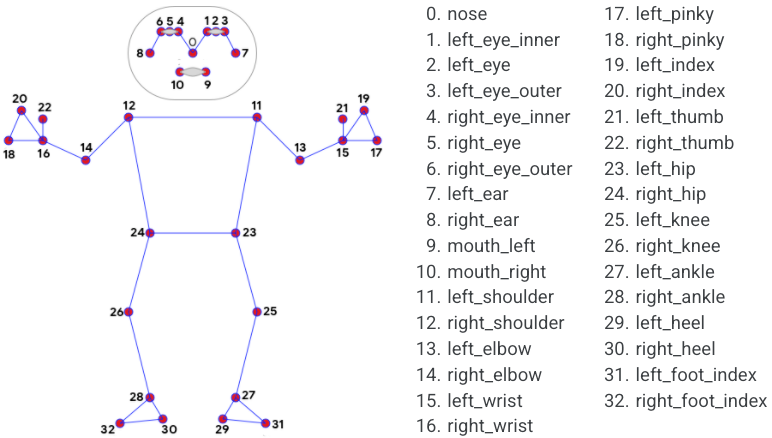

In [ ]:
def angles(data):
    """Takes coordinates from video_preprocess function and outputs the data for the different angles"""
    return np.array([angle_between(data[LEFT_WRIST], data[LEFT_ELBOW], data[LEFT_SHOULDER]),\
    angle_between(data[LEFT_HIP], data[LEFT_SHOULDER], data[LEFT_ELBOW]),\
    angle_between(data[LEFT_SHOULDER], data[LEFT_HIP], data[LEFT_KNEE]),\
    angle_between(data[LEFT_HIP], data[LEFT_KNEE], data[LEFT_ANKLE]),\
    angle_between(data[LEFT_KNEE], data[LEFT_ANKLE], data[LEFT_FOOT_INDEX]),\
    angle_between(data[RIGHT_WRIST], data[RIGHT_ELBOW], data[RIGHT_SHOULDER]),\
    angle_between(data[RIGHT_HIP], data[RIGHT_SHOULDER], data[RIGHT_ELBOW]),\
    angle_between(data[RIGHT_SHOULDER], data[RIGHT_HIP], data[RIGHT_KNEE]),\
    angle_between(data[RIGHT_HIP], data[RIGHT_KNEE], data[RIGHT_ANKLE]),\
    angle_between(data[RIGHT_KNEE], data[RIGHT_ANKLE], data[RIGHT_FOOT_INDEX])])


In [ ]:
#Create X
import os


video_path = "../raw_data/cutted/"
cutted = os.listdir(video_path)

In [2]:
def extract_X_y_angles(lst, y_val=0):
    
    
    X = []
    y = []
    
    for ind, i in enumerate(lst):
        coords = video_preprocess(i)
        
        jiggle_angles = []
        for i in coords:
            jiggle_angles.append(angles(i))

        X.append(np.array(jiggle_angles))
        y.append(y_val)
        print(f'Finished processing {ind+1} out of {len(lst)}.')
    
    return np.array(X), np.array(y)

In [ ]:
extract_X_y(cutted[:5], y_val=1)

In [ ]:
extract_X_y(['../testdance.mp4'], 0)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_pad = pad_sequences(X, padding='post', dtype='float64',value=np.zeros(10,))

In [ ]:
X_pad.shape

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

In [ ]:
model = Sequential([SimpleRNN(10),
                    Dense(10),
                    Dense(50),
                    Dense(1, activation='sigmoid')])

In [ ]:
model.compile(loss='mse',
             optimizer='adam')

In [ ]:
model.fit(X_pad,y, epochs = 500)